# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = {item:i for i, item in enumerate(self.word2vec.keys())}
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        if type(w)==str:
            similarities = [self.score(self.word2vec[w], self.word2vec[self.id2word[i]]) for i in range(len(self.word2id))]
        else:
            similarities = [self.score(w, self.word2vec[self.id2word[i]]) for i in range(len(self.word2id))]
        closest_k = np.argsort(similarities)[::-1][:K]
        results = [self.id2word[i] for i in closest_k]
        return results

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        if type(w1)==str:
            w2v1 = self.word2vec[w1]
            w2v2 = self.word2vec[w2]
        else:
            w2v1 = w1
            w2v2 = w2
        
        score = np.dot(w2v1, w2v2)  / (np.linalg.norm(w2v1)*np.linalg.norm(w2v2))
        return score

In [4]:
# need to change load number from 25,000 to 100,000 to have "Paris" for ex
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'Dog', 'doggie']
['dogs', 'dog', 'pooches', 'Dogs', 'doggies']
['paris', 'france', 'Paris', 'london', 'berlin']
['germany', 'austria', 'europe', 'german', 'berlin']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                sentemb.append(np.mean([self.w2v.word2vec[w] for w in sent if w in self.w2v.word2vec], axis=0))
            else:
                # idf-weighted mean of word vectors
                sentemb.append(np.mean([self.w2v.word2vec[w]*idf[w] for w in sent if w in self.w2v.word2vec], axis=0))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        scores = np.dot(keys, query.T)
        scores /= np.reshape(np.linalg.norm(keys, axis=1), (-1,1))
        closest_sentences = np.argsort(scores[:,0])
        closest_sentences = [sentences[i] for i in closest_sentences]
        print(closest_sentences[::-1][:K])

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        enc1 = self.encode([s1], idf)
        enc2 = self.encode([s2], idf)
        
        res = np.dot(enc1,enc2.T) \
            /(np.linalg.norm(enc1) * np.linalg.norm(enc2)) 
        
        return print(res[0,0])
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}        
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        
        idf = {w:max(1, np.log10(len(sentences) / v)) for (w,v) in idf.items()}
        return idf


In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=10000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
file = open(os.path.join(PATH_TO_DATA, 'sentences.txt'), "r")
sentences = [line.split() for line in file]

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])



s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)

Loaded 10000 pretrained word vectors
[['1', 'smiling', 'african', 'american', 'boy', '.'], ['girl', 'smiling', 'on', 'roller', 'coaster', '.'], ['a', 'boy', 'smiles', 'underwater', '.'], ['two', 'girlfriends', 'smiling', '.'], ['a', 'smiling', 'child', 'swims', '.']]
0.5936035444177407
[['1', 'smiling', 'african', 'american', 'boy', '.'], ['5', 'women', 'and', '1', 'man', 'are', 'smiling', 'for', 'the', 'camera', '.'], ['2', 'guys', 'facing', 'away', 'from', 'camera', ',', '1', 'girl', 'smiling', 'at', 'camera', 'with', 'blue', 'shirt', ',', '1', 'guy', 'with', 'a', 'beverage', 'with', 'a', 'jacket', 'on', '.'], ['two', 'girlfriends', 'smiling', '.'], ['1', 'man', 'singing', 'and', '1', 'man', 'playing', 'a', 'saxophone', 'in', 'a', 'concert', '.']]
0.5004864584233165


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
w2v_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)


Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
dictX = {w: w2v_fr.word2vec[w] for w in w2v_en.word2vec if w in w2v_fr.word2vec}
dictY = {w: w2v_en.word2vec[w] for w in dictX}

X = np.array([dictX[w] for w in dictX]).T
Y = np.array([dictY[w] for w in dictX]).T

In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
U, S, V = np.linalg.svd(np.dot(Y, X.T), full_matrices=False)
W = np.dot(U, V)
W_inv = np.linalg.inv(W)

In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
print('From French to English')
for w in ['voiture', 'facebook', 'nettoyé', 'jacques', 'avant','robuste']:
    emb = np.dot(W, w2v_fr.word2vec[w])
    print('Most similar words for %s are : ' %  w, str(w2v_en.most_similar(emb)))
    
print('\n')

print('From English to French')
for w in ['manifold', 'actually', 'fake', 'learning','love']:
    emb = np.dot(W_inv, w2v_en.word2vec[w])
    print('Most similar words for %s are : ' % w, str(w2v_fr.most_similar(emb)) )

From French to English
Most similar words for voiture are :  ['car', 'cars', 'limousine', 'suv', 'roadster']
Most similar words for facebook are :  ['facebook', 'twitter', 'myspace', 'reddit', 'tumblr']
Most similar words for nettoyé are :  ['cleaned', 'vandalized', 'cleaning', 'removing', 'vandalised']
Most similar words for jacques are :  ['jacques', 'françois', 'jean', 'henri', 'philippe']
Most similar words for avant are :  ['before', 'shortly', 'être', 'avant', 'immediately']
Most similar words for robuste are :  ['robust', 'sturdy', 'agile', 'resilient', 'adaptable']


From English to French
Most similar words for manifold are :  ['topologique', 'ℝ', 'euclidien', 'isomorphisme', 'abélien']
Most similar words for actually are :  ['would', 'should', 'could', 'that', 'really']
Most similar words for fake are :  ['fake', 'arnaque', 'fuck', 'canulars', 'canular']
Most similar words for learning are :  ['learning', 'education', 'apprentissage', 'apprentissages', 'educational']
Most sim

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
train_data = []
labels_train = []
file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'), "r")
for line in file:
    train_data.append(line.split()[1:]) 
    labels_train.append(line.split()[0])
labels_train = [int(labels_train[i]) for i in range(len(labels_train))]

# validation
valid_data = []
labels_valid = []
file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'), "r")
for line in file:
    valid_data.append(line.split()[1:])
    labels_valid.append(line.split()[0])
labels_valid = [int(labels_valid[i]) for i in range(len(labels_valid))]

# test
test_data = []
file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'), "r")
for line in file:
    test_data.append(line.split())

In [12]:
# 2 - Encode sentences with the BoV model above

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=10000)
s2v = BoV(w2v)

idf = s2v.build_idf(train_data + valid_data + test_data)

encoded_train_data = s2v.encode(train_data, False)
encoded_valid_data = s2v.encode(valid_data, False)
encoded_test_data = s2v.encode(test_data, False)

encoded_train_data_weighted = s2v.encode(train_data, idf)
encoded_valid_data_weighted = s2v.encode(valid_data, idf)
encoded_test_data_weighted = s2v.encode(test_data, idf)

Loaded 10000 pretrained word vectors


In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn import preprocessing
from sklearn import linear_model

scaler1 = preprocessing.StandardScaler().fit(encoded_train_data)
normalized_encoded_train_data = scaler1.transform(encoded_train_data)
normalized_encoded_valid_data = scaler1.transform(encoded_valid_data)
normalized_encoded_test_data = scaler1.transform(encoded_test_data)

scaler2 = preprocessing.StandardScaler().fit(encoded_train_data_weighted)
normalized_encoded_train_data_weighted = scaler2.transform(encoded_train_data_weighted)
normalized_encoded_valid_data_weighted = scaler2.transform(encoded_valid_data_weighted)
normalized_encoded_test_data_weighted = scaler2.transform(encoded_test_data_weighted)

logreg_model1 = linear_model.LogisticRegression(C=1,penalty='l2',tol=1e-6)
logreg_model1.fit(normalized_encoded_train_data, labels_train)

logreg_model2 = linear_model.LogisticRegression(C=1,penalty='l2',tol=1e-6)
logreg_model2.fit(normalized_encoded_train_data_weighted, labels_train)

print('Train score: %.3f ' % logreg_model1.score(normalized_encoded_train_data, labels_train))
print('Valid score: %.3f' % logreg_model1.score(normalized_encoded_valid_data,labels_valid))

print('Train score (weighted): %.3f ' % logreg_model2.score(normalized_encoded_train_data, labels_train))
print('Valid score (weighted): %.3f' % logreg_model2.score(normalized_encoded_valid_data,labels_valid))

Train score: 0.471 
Valid score: 0.400
Train score (weighted): 0.450 
Valid score (weighted): 0.399


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.


prediction_test=logreg_model1.predict(normalized_encoded_test_data)

with open('./logreg_bov_y_test_sst.txt', 'w') as f1:
    for k in prediction_test:
        f1.write(str(k) + os.linesep)

In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

import lightgbm as lgb

gboost_model = lgb.LGBMClassifier(objective='multiclass', n_estimators=2000, reg_lambda=5000)
gboost_model.fit(normalized_encoded_train_data_weighted, labels_train,
                   eval_set=[(normalized_encoded_valid_data_weighted, labels_valid)], early_stopping_rounds=20)

print('Train score: %.3f ' % gboost_model.score(normalized_encoded_train_data_weighted, labels_train))
print('Valid score: %.3f' % gboost_model.score(normalized_encoded_valid_data_weighted, labels_valid))

prediction_test = gboost_model.predict(normalized_encoded_test_data_weighted)
with open('./gboost_bov_y_test_sst.txt', 'w') as f1:
    for k in prediction_test:
        f1.write(str(k) + os.linesep)


[1]	valid_0's multi_logloss: 1.60681
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's multi_logloss: 1.60428
[3]	valid_0's multi_logloss: 1.60185
[4]	valid_0's multi_logloss: 1.59953
[5]	valid_0's multi_logloss: 1.59729
[6]	valid_0's multi_logloss: 1.5951
[7]	valid_0's multi_logloss: 1.59304
[8]	valid_0's multi_logloss: 1.59095
[9]	valid_0's multi_logloss: 1.58899
[10]	valid_0's multi_logloss: 1.58703
[11]	valid_0's multi_logloss: 1.58518
[12]	valid_0's multi_logloss: 1.58338
[13]	valid_0's multi_logloss: 1.58173
[14]	valid_0's multi_logloss: 1.58003
[15]	valid_0's multi_logloss: 1.57846
[16]	valid_0's multi_logloss: 1.57683
[17]	valid_0's multi_logloss: 1.57529
[18]	valid_0's multi_logloss: 1.57382
[19]	valid_0's multi_logloss: 1.57232
[20]	valid_0's multi_logloss: 1.57091
[21]	valid_0's multi_logloss: 1.5695
[22]	valid_0's multi_logloss: 1.5681
[23]	valid_0's multi_logloss: 1.56683
[24]	valid_0's multi_logloss: 1.56551
[25]	valid_0's multi_logloss: 1.56431


[214]	valid_0's multi_logloss: 1.48106
[215]	valid_0's multi_logloss: 1.48091
[216]	valid_0's multi_logloss: 1.48077
[217]	valid_0's multi_logloss: 1.48053
[218]	valid_0's multi_logloss: 1.48034
[219]	valid_0's multi_logloss: 1.4801
[220]	valid_0's multi_logloss: 1.47984
[221]	valid_0's multi_logloss: 1.47965
[222]	valid_0's multi_logloss: 1.47941
[223]	valid_0's multi_logloss: 1.47917
[224]	valid_0's multi_logloss: 1.47896
[225]	valid_0's multi_logloss: 1.47874
[226]	valid_0's multi_logloss: 1.47856
[227]	valid_0's multi_logloss: 1.47843
[228]	valid_0's multi_logloss: 1.47817
[229]	valid_0's multi_logloss: 1.47804
[230]	valid_0's multi_logloss: 1.47791
[231]	valid_0's multi_logloss: 1.47777
[232]	valid_0's multi_logloss: 1.4776
[233]	valid_0's multi_logloss: 1.47734
[234]	valid_0's multi_logloss: 1.47713
[235]	valid_0's multi_logloss: 1.47702
[236]	valid_0's multi_logloss: 1.47685
[237]	valid_0's multi_logloss: 1.4767
[238]	valid_0's multi_logloss: 1.47657
[239]	valid_0's multi_loglos

[426]	valid_0's multi_logloss: 1.44983
[427]	valid_0's multi_logloss: 1.44967
[428]	valid_0's multi_logloss: 1.44958
[429]	valid_0's multi_logloss: 1.44944
[430]	valid_0's multi_logloss: 1.44929
[431]	valid_0's multi_logloss: 1.44915
[432]	valid_0's multi_logloss: 1.44907
[433]	valid_0's multi_logloss: 1.44894
[434]	valid_0's multi_logloss: 1.44881
[435]	valid_0's multi_logloss: 1.44867
[436]	valid_0's multi_logloss: 1.4486
[437]	valid_0's multi_logloss: 1.4485
[438]	valid_0's multi_logloss: 1.4484
[439]	valid_0's multi_logloss: 1.44827
[440]	valid_0's multi_logloss: 1.4482
[441]	valid_0's multi_logloss: 1.44806
[442]	valid_0's multi_logloss: 1.44797
[443]	valid_0's multi_logloss: 1.44783
[444]	valid_0's multi_logloss: 1.4477
[445]	valid_0's multi_logloss: 1.44757
[446]	valid_0's multi_logloss: 1.44748
[447]	valid_0's multi_logloss: 1.44728
[448]	valid_0's multi_logloss: 1.44727
[449]	valid_0's multi_logloss: 1.44718
[450]	valid_0's multi_logloss: 1.44708
[451]	valid_0's multi_logloss:

[639]	valid_0's multi_logloss: 1.43353
[640]	valid_0's multi_logloss: 1.43342
[641]	valid_0's multi_logloss: 1.43334
[642]	valid_0's multi_logloss: 1.43327
[643]	valid_0's multi_logloss: 1.43314
[644]	valid_0's multi_logloss: 1.43315
[645]	valid_0's multi_logloss: 1.43315
[646]	valid_0's multi_logloss: 1.43308
[647]	valid_0's multi_logloss: 1.43305
[648]	valid_0's multi_logloss: 1.43297
[649]	valid_0's multi_logloss: 1.43289
[650]	valid_0's multi_logloss: 1.4328
[651]	valid_0's multi_logloss: 1.4327
[652]	valid_0's multi_logloss: 1.43259
[653]	valid_0's multi_logloss: 1.4326
[654]	valid_0's multi_logloss: 1.43257
[655]	valid_0's multi_logloss: 1.4325
[656]	valid_0's multi_logloss: 1.43243
[657]	valid_0's multi_logloss: 1.43234
[658]	valid_0's multi_logloss: 1.43229
[659]	valid_0's multi_logloss: 1.43228
[660]	valid_0's multi_logloss: 1.43224
[661]	valid_0's multi_logloss: 1.43221
[662]	valid_0's multi_logloss: 1.4321
[663]	valid_0's multi_logloss: 1.43198
[664]	valid_0's multi_logloss:

[850]	valid_0's multi_logloss: 1.42459
[851]	valid_0's multi_logloss: 1.42457
[852]	valid_0's multi_logloss: 1.42458
[853]	valid_0's multi_logloss: 1.42456
[854]	valid_0's multi_logloss: 1.42451
[855]	valid_0's multi_logloss: 1.42447
[856]	valid_0's multi_logloss: 1.42444
[857]	valid_0's multi_logloss: 1.42437
[858]	valid_0's multi_logloss: 1.4243
[859]	valid_0's multi_logloss: 1.42431
[860]	valid_0's multi_logloss: 1.42429
[861]	valid_0's multi_logloss: 1.42426
[862]	valid_0's multi_logloss: 1.42417
[863]	valid_0's multi_logloss: 1.42416
[864]	valid_0's multi_logloss: 1.42415
[865]	valid_0's multi_logloss: 1.42409
[866]	valid_0's multi_logloss: 1.42412
[867]	valid_0's multi_logloss: 1.42405
[868]	valid_0's multi_logloss: 1.42401
[869]	valid_0's multi_logloss: 1.42405
[870]	valid_0's multi_logloss: 1.42403
[871]	valid_0's multi_logloss: 1.424
[872]	valid_0's multi_logloss: 1.42397
[873]	valid_0's multi_logloss: 1.42391
[874]	valid_0's multi_logloss: 1.42391
[875]	valid_0's multi_loglos

[1061]	valid_0's multi_logloss: 1.41892
[1062]	valid_0's multi_logloss: 1.41892
[1063]	valid_0's multi_logloss: 1.41888
[1064]	valid_0's multi_logloss: 1.41886
[1065]	valid_0's multi_logloss: 1.41887
[1066]	valid_0's multi_logloss: 1.41888
[1067]	valid_0's multi_logloss: 1.41877
[1068]	valid_0's multi_logloss: 1.41873
[1069]	valid_0's multi_logloss: 1.41871
[1070]	valid_0's multi_logloss: 1.41868
[1071]	valid_0's multi_logloss: 1.41868
[1072]	valid_0's multi_logloss: 1.41868
[1073]	valid_0's multi_logloss: 1.41864
[1074]	valid_0's multi_logloss: 1.41862
[1075]	valid_0's multi_logloss: 1.41857
[1076]	valid_0's multi_logloss: 1.41848
[1077]	valid_0's multi_logloss: 1.41841
[1078]	valid_0's multi_logloss: 1.41846
[1079]	valid_0's multi_logloss: 1.41844
[1080]	valid_0's multi_logloss: 1.41842
[1081]	valid_0's multi_logloss: 1.41838
[1082]	valid_0's multi_logloss: 1.41834
[1083]	valid_0's multi_logloss: 1.41831
[1084]	valid_0's multi_logloss: 1.41822
[1085]	valid_0's multi_logloss: 1.41818


[1268]	valid_0's multi_logloss: 1.41508
[1269]	valid_0's multi_logloss: 1.4151
[1270]	valid_0's multi_logloss: 1.4151
[1271]	valid_0's multi_logloss: 1.41505
[1272]	valid_0's multi_logloss: 1.41502
[1273]	valid_0's multi_logloss: 1.41504
[1274]	valid_0's multi_logloss: 1.41504
[1275]	valid_0's multi_logloss: 1.41498
[1276]	valid_0's multi_logloss: 1.41495
[1277]	valid_0's multi_logloss: 1.41492
[1278]	valid_0's multi_logloss: 1.41491
[1279]	valid_0's multi_logloss: 1.41492
[1280]	valid_0's multi_logloss: 1.4149
[1281]	valid_0's multi_logloss: 1.41491
[1282]	valid_0's multi_logloss: 1.41489
[1283]	valid_0's multi_logloss: 1.4149
[1284]	valid_0's multi_logloss: 1.41487
[1285]	valid_0's multi_logloss: 1.41486
[1286]	valid_0's multi_logloss: 1.41485
[1287]	valid_0's multi_logloss: 1.41482
[1288]	valid_0's multi_logloss: 1.41479
[1289]	valid_0's multi_logloss: 1.41481
[1290]	valid_0's multi_logloss: 1.41478
[1291]	valid_0's multi_logloss: 1.41471
[1292]	valid_0's multi_logloss: 1.41472
[129

[1476]	valid_0's multi_logloss: 1.4132
[1477]	valid_0's multi_logloss: 1.41315
[1478]	valid_0's multi_logloss: 1.41312
[1479]	valid_0's multi_logloss: 1.41309
[1480]	valid_0's multi_logloss: 1.41308
[1481]	valid_0's multi_logloss: 1.41312
[1482]	valid_0's multi_logloss: 1.41306
[1483]	valid_0's multi_logloss: 1.41303
[1484]	valid_0's multi_logloss: 1.41298
[1485]	valid_0's multi_logloss: 1.41296
[1486]	valid_0's multi_logloss: 1.41299
[1487]	valid_0's multi_logloss: 1.41294
[1488]	valid_0's multi_logloss: 1.41296
[1489]	valid_0's multi_logloss: 1.41292
[1490]	valid_0's multi_logloss: 1.41294
[1491]	valid_0's multi_logloss: 1.41295
[1492]	valid_0's multi_logloss: 1.41291
[1493]	valid_0's multi_logloss: 1.41293
[1494]	valid_0's multi_logloss: 1.41293
[1495]	valid_0's multi_logloss: 1.41291
[1496]	valid_0's multi_logloss: 1.41292
[1497]	valid_0's multi_logloss: 1.4129
[1498]	valid_0's multi_logloss: 1.41289
[1499]	valid_0's multi_logloss: 1.41291
[1500]	valid_0's multi_logloss: 1.41296
[1

d:\joel\1.2017-3a\1.oma\deeplearning\deep-learning-course\dl-venv\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train score: 0.818 


d:\joel\1.2017-3a\1.oma\deeplearning\deep-learning-course\dl-venv\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Valid score: 0.381


d:\joel\1.2017-3a\1.oma\deeplearning\deep-learning-course\dl-venv\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [16]:
import keras

d:\joel\1.2017-3a\1.oma\deeplearning\deep-learning-course\dl-venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "data/"

# TYPE CODE HERE
from keras.utils import to_categorical

n_classes=5

words=[]
sentences_train = []
Y_train = []
file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'), "r")
for row in file:
    sentences_train.append(row[1:])
    Y_train.append(row[0])
    for w in row.split()[1:]:
        words.append(w)

sentences_valid = []
Y_valid = []
file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'), "r")
for row in file:
    sentences_valid.append(row[1:])
    Y_valid.append(row[0])
    for w in row.split()[1:]:
        words.append(w)

sentences_test = []
file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'), "r")
for row in file:
    sentences_test.append(row)
    for w in row.split():
        words.append(w)
        
Y_valid_temp = [int(l) for l in Y_valid]
Y_train_temp = [int(l) for l in Y_train]

Y_train = to_categorical(Y_train_temp, num_classes=n_classes)
Y_valid = to_categorical(Y_valid_temp, num_classes=n_classes)

vocab_size = len(words)

In [18]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing.text import one_hot

X_train = [one_hot(sentence, vocab_size) for sentence in sentences_train]
X_valid = [one_hot(sentence, vocab_size) for sentence in sentences_valid]
X_test = [one_hot(sentence, vocab_size) for sentence in sentences_test]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [19]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences

maxseqlen = 50

X_train = pad_sequences(X_train, maxseqlen)
X_valid = pad_sequences(X_valid, maxseqlen)
X_test = pad_sequences(X_test, maxseqlen)

## 4.2 - Design and train your model

In [20]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = len(words)  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.4, dropout_U=0.4))
model.add(Dense(n_classes, activation='sigmoid'))


d:\joel\1.2017-3a\1.oma\deeplearning\deep-learning-course\dl-venv\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.4, recurrent_dropout=0.4)`


In [21]:
# 5 - Define your loss/optimizer/metrics
# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy'# find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          7271840   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 7,296,997
Trainable params: 7,296,997
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 19s 2ms/step - loss: 1.5783 - acc: 0.2725 - val_loss: 1.5723 - val_acc: 0.2534
Epoch 2/6
8544/8544 [==============================] - 18s 2ms/step - loss: 1.5379 - acc: 0.3076 - val_loss: 1.4794 - val_acc: 0.3660
Epoch 3/6
8544/8544 [==============================] - 18s 2ms/step - loss: 1.3540 - acc: 0.4228 - val_loss: 1.3908 - val_acc: 0.3951
Epoch 4/6
8544/8544 [==============================] - 17s 2ms/step - loss: 1.1397 - acc: 0.4913 - val_loss: 1.3792 - val_acc: 0.4033
Epoch 5/6
8544/8544 [==============================] - 17s 2ms/step - loss: 0.9534 - acc: 0.5939 - val_loss: 1.5225 - val_acc: 0.4033
Epoch 6/6
8544/8544 [==============================] - 18s 2ms/step - loss: 0.7857 - acc: 0.6935 - val_loss: 1.6034 - val_acc: 0.3760


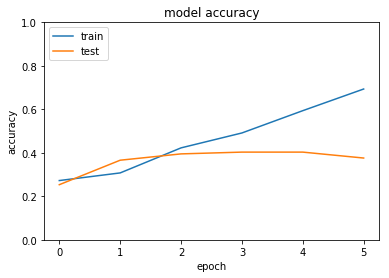

In [22]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
%matplotlib inline
import matplotlib.pyplot as plt
bs = 64
n_epochs = 6

history = model.fit(X_train, Y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_valid, Y_valid))

#Model Visualisation
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
axes = plt.gca()
axes.set_ylim([0,1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
pred_test = np.argmax(model.predict(X_test),axis=1)
with open('./logreg_lstm_y_test_sst.txt', 'w') as f1:
    for k in pred_test:
        f1.write(str(k) + os.linesep)

## 4.3 -- innovate !

In [24]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
import lightgbm as lgb

gboost_model = lgb.LGBMClassifier(objective='multiclass', n_estimators=2000, reg_lambda=10)
gboost_model.fit(X_train, Y_train_temp, verbose=False,
                   eval_set=[(X_valid, Y_valid_temp)], early_stopping_rounds=50)

print('Train score: %.3f ' % gboost_model.score(X_train, Y_train_temp))
print('Valid score: %.3f' % gboost_model.score(X_valid, Y_valid_temp))


Train score: 0.518 
Valid score: 0.295


d:\joel\1.2017-3a\1.oma\deeplearning\deep-learning-course\dl-venv\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\joel\1.2017-3a\1.oma\deeplearning\deep-learning-course\dl-venv\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [25]:
pred_test = np.argmax(model.predict(X_test),axis=1)
with open('./gboost_test_sst.txt', 'w') as f1:
    for k in pred_test:
        f1.write(str(k) + os.linesep)